# How to create an boundary condition file from a global dataset (here GECCO)

This example shows how to create an Boundary condition file for MITgcm from a global model (here GECCO). The method is similar than creating the initial condition but has to be made for all steps. In order to save memory, we extract the data for the OBC for every step.

We are gonna use essentially xarray and packages developed in-house: xmitgcm and MITgcm_recipes

https://github.com/xgcm/xmitgcm

https://github.com/raphaeldussin/MITgcm-recipes

In [1]:
import xarray as xr
import xmitgcm
import MITgcm_recipes

In [2]:
import tqdm
import numpy as np

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 0. Datasets

We need the input dataset (here GECCO), the raw grid from MITgcm (as given by tile00?.mitgrid) that doesn't have holes where land processors are eliminated and one realization of the model for depth vector and grid angles.

#### GECCO is stored locally on our server in netcdf format and loaded with xarray:

In [4]:
geccodir='/local/data/artemis/workspace/rdussin/Simulations/GECCO2/rechunked/'

tempfile = geccodir + 'temp29_34_70.nc'
saltfile = geccodir + 'salt29_34_70.nc'
sshfile = geccodir + 'zeta29_34_70.nc'
uzofile = geccodir + 'u29_34_70.nc'
vmefile = geccodir + 'v29_34_70.nc'

# we need to split by point-type to avoid xarray broadcast (makes larger arrays)
gecco_T = xr.open_mfdataset([tempfile, saltfile, sshfile], decode_times=False, chunks={'time':1})
gecco_U = xr.open_dataset(uzofile, decode_times=False, chunks={'time':1})
gecco_V = xr.open_dataset(vmefile, decode_times=False, chunks={'time':1})

#### ASTE raw grid can be read from a netcdf produced with xmitgcm reading tile00?.mitgrid

In [5]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

In [6]:
aste_raw

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, i_g: 270, j: 270, j_g: 270)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5
Data variables:
    XC       (face, j, i) float64 ...
    YC       (face, j, i) float64 ...
    DXF      (face, j, i) float64 ...
    DYF      (face, j, i) float64 ...
    RAC      (face, j, i) float64 ...
    XG       (face, j_g, i_g) float64 ...
    YG       (face, j_g, i_g) float64 ...
    DXV      (face, j, i) float64 ...
    DYU      (face, j, i) float64 ...
    RAZ      (face, j_g, i_g) float64 ...
    DXC      (face, j, i_g) float64 ...
    DYC      (face, j_g, i) float64 ...
    RAW      (face, j, i_g) float64 ...
    RAS      (face, j_g, i)

**Here the variables of interest are gonna be XC, YC and XG, YG which are longitude/latitudes for cell centers and edges**

#### Sample ASTE run needed for angles/depth available at:

In [7]:
datadir_aste = '/local/data/artemis/workspace/rdussin/ASTE/RUNS/ASTE-Phy-Release1/outputs/'
md = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)
aste_out = xmitgcm.open_mdsdataset(datadir_aste, iters=[], prefix=['T','S','Eta','U','V'],
                                   geometry='llc', nx=270, extra_metadata=md)

In [8]:
aste_out

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5
    XC       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    YC       (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    XG       (face, j_g, i_g

**Here the variables of interest are CS ( = cos(angle)), SN ( = sin(angle)) and Z (depth vector) **

## 1. Tracers and SSH

In [9]:
#ntimes=len(gecco_T.time)
ntimes=3
obcs, obce = MITgcm_recipes.open_boundary.define_obc_aste()
nobcs=1170
nobce=1260
nlevs=50

temp_obcs = np.empty((ntimes, nlevs, nobcs))
temp_obce = np.empty((ntimes, nlevs, nobce))

salt_obcs = np.empty((ntimes, nlevs, nobcs))
salt_obce = np.empty((ntimes, nlevs, nobce))

zeta_obcs = np.empty((ntimes, 1, nobcs))
zeta_obce = np.empty((ntimes, 1, nobce))

# LOOP ON TIME FRAMES:
for kt in tqdm.tqdm(range(ntimes)):
    gecco_T_ic = gecco_T.isel(time=kt)
    # 1. Extrapolation onto land
    gecco_drowned_T = xr.Dataset()
    drowned_temp = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'temp', 
                                                         dims_drown=['lat', 'lon'], 
                                                         mask=None, periodicity=0)
    gecco_drowned_T.update({'temp': drowned_temp['temp']})
    drowned_salt = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'salt', 
                                                         dims_drown=['lat', 'lon'], 
                                                         mask=None, periodicity=0)
    gecco_drowned_T.update({'salt': drowned_salt['salt']})

    drowned_zeta = MITgcm_recipes.regridding.drown_field(gecco_T_ic, 'zeta', 
                                                         dims_drown=['lat', 'lon'], 
                                                         mask=None, periodicity=0)
    gecco_drowned_T.update({'zeta': drowned_zeta['zeta']})
    
    # 2. Vertical interpolation
    # Tpoint
    gecco_drowned_Tz = MITgcm_recipes.vertical_interpolation(gecco_drowned_T, aste_out['Z'], 
                                                             ['temp', 'salt'],
                                                             lonvar='lon', latvar='lat',
                                                             depth_varin='Depth',
                                                             timevar=None)

    # add ssh (2d) to resulting dataset
    gecco_drowned_Tz.update({'zeta':gecco_drowned_T['zeta']})
    
    # 3. Regridding
    regrid_T = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Tz, aste_raw, 
                                                             ['temp', 'salt', 'zeta'], 
                                                             method='bilinear',
                                                             lonname='lon', latname='lat', 
                                                             point='T', faces2blend=[2], 
                                                             periodic=True, reuse_weights=True,
                                                             regridname='regrid_T2T_face')
    
    # 4. Mask the end result
    masked_temp = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.temp, aste_out, point='T')
    masked_salt = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.salt, aste_out, point='T')
    masked_zeta = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.zeta, aste_out, point='T')
    
    # 5. Extract the OBC
    temp_obcs[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_temp.expand_dims('time'), 
                                                                     obcs, 1170, 50, 1)
    temp_obce[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_temp.expand_dims('time'), 
                                                                     obce, 1260, 50, 1)
    
    salt_obcs[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_salt.expand_dims('time'), 
                                                                     obcs, 1170, 50, 1)
    salt_obce[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_salt.expand_dims('time'), 
                                                                     obce, 1260, 50, 1)
    
    zeta_obcs[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_zeta.expand_dims('time'), 
                                                                     obcs, 1170, 1, 1)
    zeta_obce[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_zeta.expand_dims('time'), 
                                                                     obce, 1260, 1, 1)

# Write to file
xmitgcm.utils.write_to_binary(temp_obcs.flatten(), 'temp_GECCO_obc_south.bin', precision='single')
xmitgcm.utils.write_to_binary(temp_obce.flatten(), 'temp_GECCO_obc_east.bin', precision='single')

xmitgcm.utils.write_to_binary(salt_obcs.flatten(), 'salt_GECCO_obc_south.bin', precision='single')
xmitgcm.utils.write_to_binary(salt_obce.flatten(), 'salt_GECCO_obc_east.bin', precision='single')

xmitgcm.utils.write_to_binary(zeta_obcs.flatten(), 'zeta_GECCO_obc_south.bin', precision='single')
xmitgcm.utils.write_to_binary(zeta_obce.flatten(), 'zeta_GECCO_obc_east.bin', precision='single')

  0%|          | 0/3 [00:00<?, ?it/s]

Reuse existing file: regrid_T2T_0.nc
Reuse existing file: regrid_T2T_1.nc
Reuse existing file: regrid_T2T_2.nc
Reuse existing file: backup_regrid_T2T_2.nc
Reuse existing file: regrid_T2T_3.nc
Reuse existing file: regrid_T2T_4.nc
Reuse existing file: regrid_T2T_5.nc


 33%|███▎      | 1/3 [00:05<00:10,  5.03s/it]

Reuse existing file: regrid_T2T_0.nc
Reuse existing file: regrid_T2T_1.nc
Reuse existing file: regrid_T2T_2.nc
Reuse existing file: backup_regrid_T2T_2.nc
Reuse existing file: regrid_T2T_3.nc
Reuse existing file: regrid_T2T_4.nc
Reuse existing file: regrid_T2T_5.nc


 67%|██████▋   | 2/3 [00:15<00:07,  7.99s/it]

Reuse existing file: regrid_T2T_0.nc
Reuse existing file: regrid_T2T_1.nc
Reuse existing file: regrid_T2T_2.nc
Reuse existing file: backup_regrid_T2T_2.nc
Reuse existing file: regrid_T2T_3.nc
Reuse existing file: regrid_T2T_4.nc
Reuse existing file: regrid_T2T_5.nc


100%|██████████| 3/3 [00:26<00:00,  8.86s/it]


## 2. Velocities

In [12]:
#ntimes=len(gecco_T.time)
ntimes=3
obcs_u, obce_u = MITgcm_recipes.open_boundary.define_obc_aste(point='U')
obcs_v, obce_v = MITgcm_recipes.open_boundary.define_obc_aste(point='V')
nobcs=1170
nobce=1260
nlevs=50

u_obcs = np.empty((ntimes, nlevs, nobcs))
u_obce = np.empty((ntimes, nlevs, nobce))

v_obcs = np.empty((ntimes, nlevs, nobcs))
v_obce = np.empty((ntimes, nlevs, nobce))

# LOOP ON TIME FRAMES:
for kt in tqdm.tqdm(range(ntimes)):
    gecco_U_ic = gecco_U.isel(time=kt)
    gecco_V_ic = gecco_V.isel(time=kt)
    # 1. Extrapolation onto land
    gecco_drowned_U = MITgcm_recipes.regridding.drown_field(gecco_U_ic, 'u', 
                                                            dims_drown=['lat', 'lon'], 
                                                            mask=None, periodicity=0)

    gecco_drowned_V = MITgcm_recipes.regridding.drown_field(gecco_V_ic, 'v', 
                                                            dims_drown=['lat', 'lon'], 
                                                            mask=None, periodicity=0)
    
    # 2. Vertical interpolation
    # U point
    gecco_drowned_Uz = MITgcm_recipes.vertical_interpolation(gecco_drowned_U, 
                                                             aste_out['Z'], ['u'],
                                                             lonvar='lon', latvar='lat',
                                                             depth_varin='Depth',
                                                             timevar=None)

    # V point
    gecco_drowned_Vz = MITgcm_recipes.vertical_interpolation(gecco_drowned_V, 
                                                             aste_out['Z'], ['v'],
                                                             lonvar='lon', latvar='lat',
                                                             depth_varin='Depth',
                                                             timevar=None)

    # 3. Regridding : perform 4 interpolations!

    rawUvel_Upoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Uz, 
                                                                   aste_raw, ['u'], point='U',
                                                                   method='bilinear',
                                                                   periodic=True, reuse_weights=True,
                                                                   regridname='regrid_U2U_face')

    rawUvel_Vpoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Uz, 
                                                                   aste_raw, ['u'], point='V',
                                                                   method='bilinear',
                                                                   periodic=True, reuse_weights=True,
                                                                   regridname='regrid_U2V_face')

    rawVvel_Upoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Vz, 
                                                                   aste_raw, ['v'], point='U',
                                                                   method='bilinear',
                                                                   periodic=True, reuse_weights=True,
                                                                   regridname='regrid_V2U_face')

    rawVvel_Vpoint = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(gecco_drowned_Vz, 
                                                                   aste_raw, ['v'], point='V',
                                                                   method='bilinear',
                                                                   periodic=True, reuse_weights=True,
                                                                   regridname='regrid_V2V_face')
    
    # 4. Rotate the velocities
    u_aste =   rawUvel_Upoint['u'] * aste_out['CS'].rename({'i':'i_g'}) + \
               rawVvel_Upoint['v'] * aste_out['SN'].rename({'i':'i_g'})
    v_aste = - rawUvel_Vpoint['u'] * aste_out['SN'].rename({'j':'j_g'}) + \
               rawVvel_Vpoint['v'] * aste_out['CS'].rename({'j':'j_g'})
    
    # 5. mask the results
    masked_u = MITgcm_recipes.regridding.mask_output_zeros(u_aste, aste_out, point='U')
    masked_v = MITgcm_recipes.regridding.mask_output_zeros(v_aste, aste_out, point='V')
    
    # 6. Extract the OBC
    u_obcs[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_u.expand_dims('time'), 
                                                                  obcs_u, 1170, 50, 1)
    u_obce[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_u.expand_dims('time'), 
                                                                  obce_u, 1260, 50, 1)
    
    v_obcs[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_v.expand_dims('time'), 
                                                                  obcs_v, 1170, 50, 1)
    v_obce[kt,:,:] = MITgcm_recipes.open_boundary.extract_obc_raw(masked_v.expand_dims('time'), 
                                                                  obce_v, 1260, 50, 1)
    
# Write to file
xmitgcm.utils.write_to_binary(u_obcs.flatten(), 'u_GECCO_obc_south.bin', precision='single')
xmitgcm.utils.write_to_binary(u_obce.flatten(), 'u_GECCO_obc_east.bin', precision='single')

xmitgcm.utils.write_to_binary(v_obcs.flatten(), 'v_GECCO_obc_south.bin', precision='single')
xmitgcm.utils.write_to_binary(v_obce.flatten(), 'v_GECCO_obc_east.bin', precision='single')

  0%|          | 0/3 [00:00<?, ?it/s]

Reuse existing file: regrid_U2U_face0.nc
Reuse existing file: regrid_U2U_face1.nc
Reuse existing file: regrid_U2U_face2.nc
Reuse existing file: regrid_U2U_face3.nc
Reuse existing file: regrid_U2U_face4.nc
Reuse existing file: regrid_U2U_face5.nc
Reuse existing file: regrid_U2V_face0.nc
Reuse existing file: regrid_U2V_face1.nc
Reuse existing file: regrid_U2V_face2.nc
Reuse existing file: regrid_U2V_face3.nc
Reuse existing file: regrid_U2V_face4.nc
Reuse existing file: regrid_U2V_face5.nc
Reuse existing file: regrid_V2U_face0.nc
Reuse existing file: regrid_V2U_face1.nc
Reuse existing file: regrid_V2U_face2.nc
Reuse existing file: regrid_V2U_face3.nc
Reuse existing file: regrid_V2U_face4.nc
Reuse existing file: regrid_V2U_face5.nc
Reuse existing file: regrid_V2V_face0.nc
Reuse existing file: regrid_V2V_face1.nc
Reuse existing file: regrid_V2V_face2.nc
Reuse existing file: regrid_V2V_face3.nc
Reuse existing file: regrid_V2V_face4.nc
Reuse existing file: regrid_V2V_face5.nc


 33%|███▎      | 1/3 [00:07<00:14,  7.31s/it]

Reuse existing file: regrid_U2U_face0.nc
Reuse existing file: regrid_U2U_face1.nc
Reuse existing file: regrid_U2U_face2.nc
Reuse existing file: regrid_U2U_face3.nc
Reuse existing file: regrid_U2U_face4.nc
Reuse existing file: regrid_U2U_face5.nc
Reuse existing file: regrid_U2V_face0.nc
Reuse existing file: regrid_U2V_face1.nc
Reuse existing file: regrid_U2V_face2.nc
Reuse existing file: regrid_U2V_face3.nc
Reuse existing file: regrid_U2V_face4.nc
Reuse existing file: regrid_U2V_face5.nc
Reuse existing file: regrid_V2U_face0.nc
Reuse existing file: regrid_V2U_face1.nc
Reuse existing file: regrid_V2U_face2.nc
Reuse existing file: regrid_V2U_face3.nc
Reuse existing file: regrid_V2U_face4.nc
Reuse existing file: regrid_V2U_face5.nc
Reuse existing file: regrid_V2V_face0.nc
Reuse existing file: regrid_V2V_face1.nc
Reuse existing file: regrid_V2V_face2.nc
Reuse existing file: regrid_V2V_face3.nc
Reuse existing file: regrid_V2V_face4.nc
Reuse existing file: regrid_V2V_face5.nc


 67%|██████▋   | 2/3 [00:20<00:10, 10.13s/it]

Reuse existing file: regrid_U2U_face0.nc
Reuse existing file: regrid_U2U_face1.nc
Reuse existing file: regrid_U2U_face2.nc
Reuse existing file: regrid_U2U_face3.nc
Reuse existing file: regrid_U2U_face4.nc
Reuse existing file: regrid_U2U_face5.nc
Reuse existing file: regrid_U2V_face0.nc
Reuse existing file: regrid_U2V_face1.nc
Reuse existing file: regrid_U2V_face2.nc
Reuse existing file: regrid_U2V_face3.nc
Reuse existing file: regrid_U2V_face4.nc
Reuse existing file: regrid_U2V_face5.nc
Reuse existing file: regrid_V2U_face0.nc
Reuse existing file: regrid_V2U_face1.nc
Reuse existing file: regrid_V2U_face2.nc
Reuse existing file: regrid_V2U_face3.nc
Reuse existing file: regrid_V2U_face4.nc
Reuse existing file: regrid_V2U_face5.nc
Reuse existing file: regrid_V2V_face0.nc
Reuse existing file: regrid_V2V_face1.nc
Reuse existing file: regrid_V2V_face2.nc
Reuse existing file: regrid_V2V_face3.nc
Reuse existing file: regrid_V2V_face4.nc
Reuse existing file: regrid_V2V_face5.nc


100%|██████████| 3/3 [00:32<00:00, 10.92s/it]


## 3. Quick check (and a coffee)

In [19]:
import matplotlib.pylab as plt
from matplotlib import cm

### 3.1 Temperature

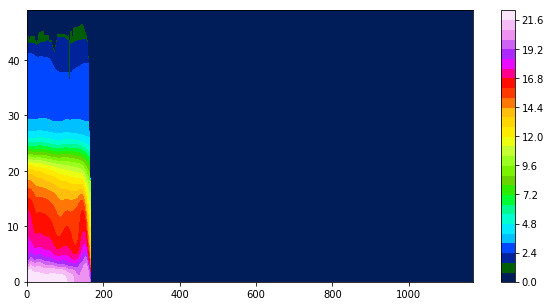

In [48]:
plt.figure(figsize=[10,5])
plt.contourf(temp_obcs[0,:,:], 30, cmap=cm.gist_ncar); plt.colorbar()

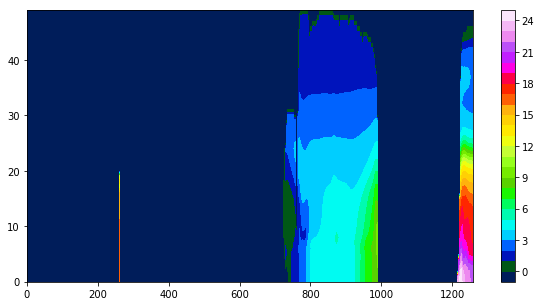

In [47]:
plt.figure(figsize=[10,5])
plt.contourf(temp_obce[0,:,:], 30, cmap=cm.gist_ncar); plt.colorbar()

### 3.2 Salinity

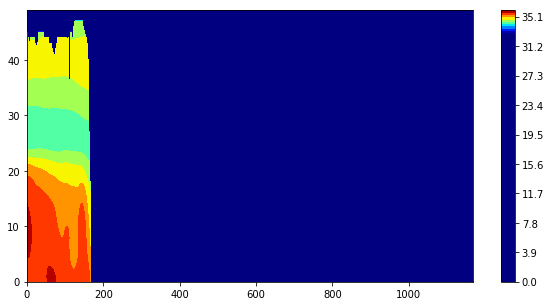

In [52]:
plt.figure(figsize=[10,5])
plt.contourf(salt_obcs[0,:,:], 120, cmap=cm.jet, vmin=33, vmax=36); plt.colorbar()

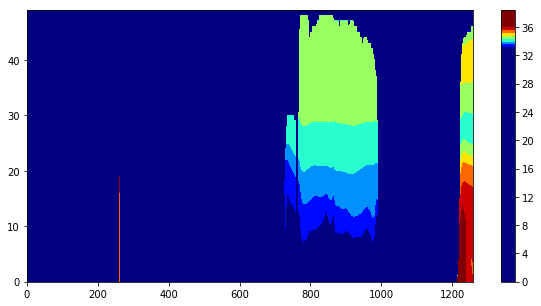

In [53]:
plt.figure(figsize=[10,5])
plt.contourf(salt_obce[0,:,:], 120, cmap=cm.jet, vmin=33, vmax=36); plt.colorbar()

### 3.3 U velocity

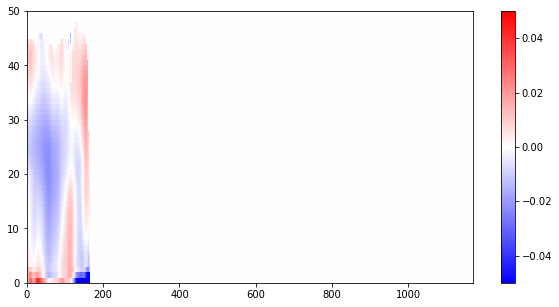

In [69]:
plt.figure(figsize=[10,5])
plt.pcolor(u_obcs[0,:,:], vmin=-0.05, vmax=0.05, cmap=cm.bwr); plt.colorbar()

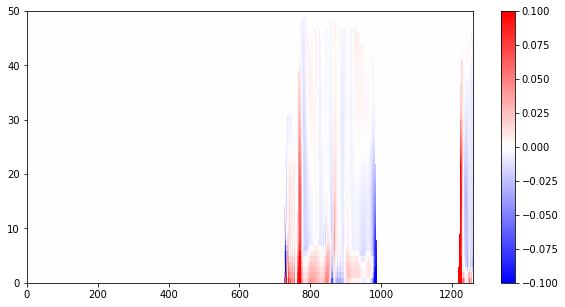

In [65]:
plt.figure(figsize=[10,5])
plt.pcolor(u_obce[0,:,:], vmin=-0.1, vmax=0.1, cmap=cm.bwr); plt.colorbar()

In [67]:
# the gibraltar point doesn't show but is in the data
u_obce[0,:,261:262]

array([[-0.08338464],
       [-0.09827919],
       [-0.10659299],
       [-0.10753442],
       [-0.10716258],
       [-0.1063381 ],
       [-0.10584439],
       [-0.1041798 ],
       [-0.10074557],
       [-0.09645337],
       [-0.09310442],
       [-0.09115606],
       [-0.0901727 ],
       [-0.08812659],
       [-0.08982232],
       [-0.08682836],
       [-0.08157831],
       [-0.07173223],
       [-0.09006002],
       [-0.11905727],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

### 3.3 V velocity

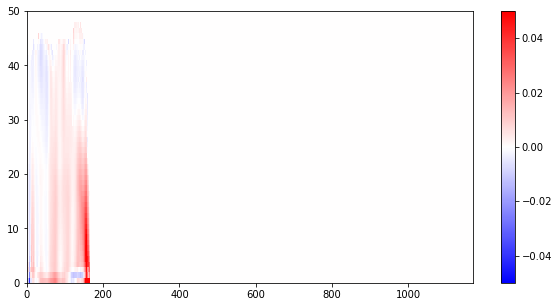

In [70]:
plt.figure(figsize=[10,5])
plt.pcolor(v_obcs[0,:,:], vmin=-0.05, vmax=0.05, cmap=cm.bwr); plt.colorbar()

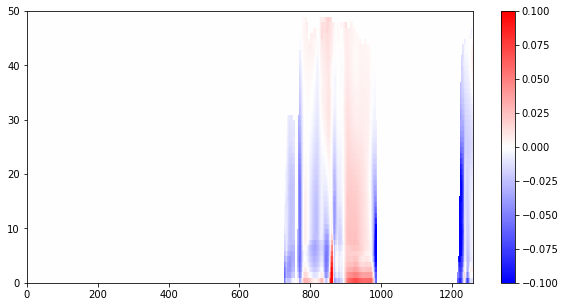

In [71]:
plt.figure(figsize=[10,5])
plt.pcolor(v_obce[0,:,:], vmin=-0.1, vmax=0.1, cmap=cm.bwr); plt.colorbar()